# Debug Grouped Environment Features

This notebook helps understand how `train_lin_grouped.py` initializes the environment and computes features like holes, bumpiness, and heights.

In [30]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from tetris_gymnasium.envs import Tetris
from tetris_gymnasium.wrappers.grouped import GroupedActionsObservations
from tetris_gymnasium.wrappers.observation import FeatureVectorObservation

In [32]:
import os
import random
import time
from dataclasses import dataclass
from typing import Callable

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tyro
from gymnasium.spaces import Box
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter

from tetris_gymnasium.envs import Tetris
from tetris_gymnasium.wrappers.grouped import GroupedActionsObservations
from tetris_gymnasium.wrappers.observation import FeatureVectorObservation


# Evaluation
def evaluate(
    model_path: str,
    make_env: Callable,
    env_id: str,
    eval_episodes: int,
    run_name: str,
    Model: torch.nn.Module,
    device: torch.device = torch.device("cpu"),
    epsilon: float = 0.05,
    capture_video: bool = True,
):
    envs = gym.vector.SyncVectorEnv([make_env(env_id, 0, 0, capture_video, run_name)])
    model = Model(envs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    obs, _ = envs.reset()
    episodic_returns = []
    while len(episodic_returns) < eval_episodes:
        if random.random() < epsilon:
            actions = np.array(
                [envs.single_action_space.sample() for _ in range(envs.num_envs)]
            )
        else:
            q_values = model(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()
        next_obs, _, _, _, infos = envs.step(actions)
        if "final_info" in infos:
            for info in infos["final_info"]:
                if "episode" not in info:
                    continue
                # print(
                #     f"eval_episode={len(episodic_returns)}, episodic_return={info['episode']['r']}"
                # )
                episodic_returns += [info["episode"]["r"]]
        obs = next_obs

    return episodic_returns




def make_env(env_id, seed, idx, capture_video, run_name):
    """
    Create environment with GroupedActionsObservations + FeatureVectorObservation.
    
    FeatureVectorObservation output order (13 features total):
    - indices 0-9: Column heights (actual height, higher = taller stack)
    - index 10: Max height
    - index 11: Number of holes
    - index 12: Bumpiness
    
    The QNetwork learns from these features directly.
    Reward shaping uses raw board from info["board"] with custom functions.
    """
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array", gravity=False)
            # FeatureVectorObservation: [heights(10), max_height(1), holes(1), bumpiness(1)]
            env = GroupedActionsObservations(
                env, observation_wrappers=[FeatureVectorObservation(env)]
            )
            env = gym.wrappers.RecordVideo(
                env,
                f"videos/{run_name}",
                episode_trigger=lambda x: x % args.video_epoch_interval == 0,
            )
        else:
            env = gym.make(env_id, render_mode="rgb_array", gravity=False)
            # FeatureVectorObservation: [heights(10), max_height(1), holes(1), bumpiness(1)]
            env = GroupedActionsObservations(
                env, observation_wrappers=[FeatureVectorObservation(env)]
            )

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk


# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        input_dim = np.array(env.single_observation_space.shape[-1])
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


def count_holes(board: np.ndarray) -> int:
    """Count holes (empty cells with a filled cell above) in a board."""
    grid = np.asarray(board)
    if grid.ndim != 2:
        return 0
    filled = grid > 0
    filled_above = np.maximum.accumulate(filled, axis=0)
    holes = (~filled) & filled_above
    return int(holes.sum())



def compute_bumpiness(board: np.ndarray) -> int:
    """Compute bumpiness (sum of absolute height differences between adjacent columns)."""
    grid = np.asarray(board)
    if grid.ndim != 2:
        return 0
    filled = grid > 0
    # Get column heights (first filled cell from top, or 0 if empty)
    heights = np.zeros(grid.shape[1], dtype=int)
    for col in range(grid.shape[1]):
        col_filled = np.where(filled[:, col])[0]
        if len(col_filled) > 0:
            heights[col] = grid.shape[0] - col_filled[0]
    # Sum of absolute differences between adjacent columns
    bumpiness = int(np.sum(np.abs(np.diff(heights))))
    return bumpiness


def compute_max_height(board: np.ndarray) -> int:
    """Compute maximum column height."""
    grid = np.asarray(board)
    if grid.ndim != 2:
        return 0
    filled = grid > 0
    for row in range(grid.shape[0]):
        if np.any(filled[row]):
            return grid.shape[0] - row
    return 0

In [34]:
# TRY NOT TO MODIFY: seeding

torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv(
    [
        make_env(args.env_id, args.seed + i, i, args.capture_video, run_name)
        for i in range(args.num_envs)
    ]
)
assert isinstance(
    envs.single_action_space, gym.spaces.Discrete
), "only discrete action space is supported"

q_network = QNetwork(envs).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
target_network = QNetwork(envs).to(device)
target_network.load_state_dict(q_network.state_dict())

rb = ReplayBuffer(
    args.buffer_size,
    Box(0.0, 200.0, (1, 13), np.float32),
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)
start_time = time.time()

# TRY NOT TO MODIFY: start the game
obs, info = envs.reset(seed=args.seed)
board = info["board"][0]
action_mask = info["action_mask"][0]

epoch = 0
global_step = 0
epoch_lines_cleared = 0

NameError: name 'args' is not defined

## 1. Create Environment (same as train_lin_grouped.py)

In [3]:
# Create env the same way as train_lin_grouped.py
env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array", render_upscale=40)
env = GroupedActionsObservations(
    env, observation_wrappers=[FeatureVectorObservation(env, report_height=True, report_max_height=True, report_holes=True, report_bumpiness=True)]
)
env = gym.wrappers.RecordEpisodeStatistics(env)

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Observation space: Box(0.0, 200.0, (40, 13), float32)
Action space: Discrete(40)


In [26]:
# After env.step(action) or env.reset()
# obs, info = env.reset()

# obs has shape (n_actions, 13) where each row is:
# For a single action observation:
obs_row = observation[30]

col_heights = obs_row[0:10]    # 10 column heights
holes = obs_row[11]            # Number of holes
bumpiness = obs_row[12]        # Bumpiness
max_height = obs_row[10]       # Max height (or total height)

print(f"Column heights: {col_heights}")
print(f"Holes: {holes}")
print(f"Bumpiness: {bumpiness}")
print(f"Max height: {max_height}")

Column heights: [8 8 8 8 0 0 0 2 2 2]
Holes: 14
Bumpiness: 10
Max height: 8


In [28]:
observation.shape

(40, 13)

In [16]:
observation, reward, terminated, truncated, info = env.step(2)

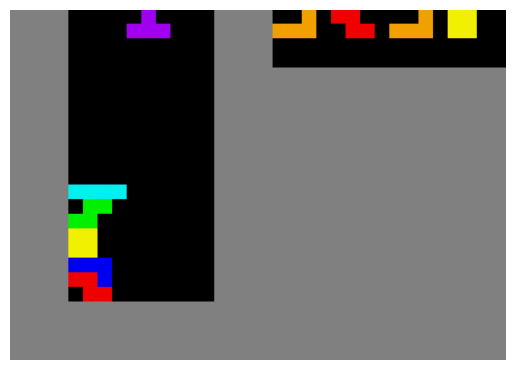

In [29]:
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [ ]:
obs[1]

array([2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 4], dtype=uint8)

: 

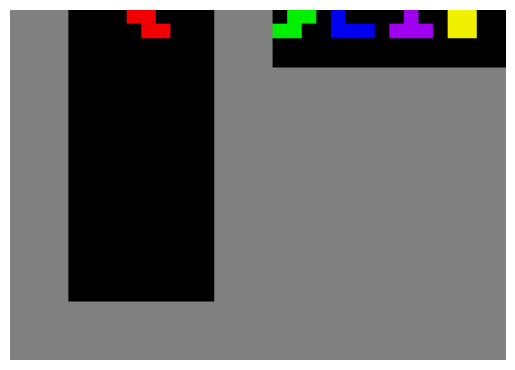

In [30]:
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

## 2. Reset and Inspect Initial State

In [24]:
obs, info = env.reset(seed=42)

print("=" * 50)
print("OBSERVATION (obs)")
print("=" * 50)
print(f"Type: {type(obs)}")
print(f"Shape: {obs.shape if hasattr(obs, 'shape') else 'N/A'}")
print(f"Dtype: {obs.dtype if hasattr(obs, 'dtype') else 'N/A'}")
print(f"\nFirst 3 rows of obs:\n{obs[:3] if hasattr(obs, '__getitem__') else obs}")

OBSERVATION (obs)
Type: <class 'numpy.ndarray'>
Shape: (40, 13)
Dtype: uint8

First 3 rows of obs:
[[1 2 2 0 0 0 0 0 0 0 2 1 3]
 [3 2 0 0 0 0 0 0 0 0 3 1 3]
 [1 2 2 0 0 0 0 0 0 0 2 1 3]]


In [25]:
print("=" * 50)
print("INFO dict keys")
print("=" * 50)
print(f"Keys: {info.keys()}")

for key, value in info.items():
    print(f"\n--- {key} ---")
    print(f"Type: {type(value)}")
    if hasattr(value, 'shape'):
        print(f"Shape: {value.shape}")
    elif isinstance(value, (list, tuple)):
        print(f"Length: {len(value)}")
        if len(value) > 0:
            print(f"First element type: {type(value[0])}")
            if hasattr(value[0], 'shape'):
                print(f"First element shape: {value[0].shape}")
    else:
        print(f"Value: {value}")

INFO dict keys
Keys: dict_keys(['lines_cleared', 'board', 'action_mask'])

--- lines_cleared ---
Type: <class 'int'>
Value: 0

--- board ---
Type: <class 'numpy.ndarray'>
Shape: (13,)

--- action_mask ---
Type: <class 'numpy.ndarray'>
Shape: (40,)


## 3. Inspect the Board

In [5]:
# Get the board from info
if "board" in info:
    board = info["board"]
    print(f"Board type: {type(board)}")
    
    # If it's a list (from vectorized env), get first element
    if isinstance(board, (list, tuple)):
        print(f"Board is a list with {len(board)} elements")
        board = board[0] if len(board) > 0 else board
        print(f"First board type: {type(board)}")
    
    # If it's a dict, extract 'board' key
    if isinstance(board, dict):
        print(f"Board is a dict with keys: {board.keys()}")
        if 'board' in board:
            board = board['board']
    
    board = np.asarray(board)
    print(f"\nFinal board shape: {board.shape}")
    print(f"Board dtype: {board.dtype}")
    print(f"\nUnique values in board: {np.unique(board)}")
    print(f"\nBoard preview (first 5 rows):\n{board[:5]}")
else:
    print("'board' not found in info!")
    print(f"Available keys: {info.keys()}")

Board type: <class 'numpy.ndarray'>

Final board shape: (13,)
Board dtype: uint8

Unique values in board: [0]

Board preview (first 5 rows):
[0 0 0 0 0]


TypeError: Invalid shape (13,) for image data

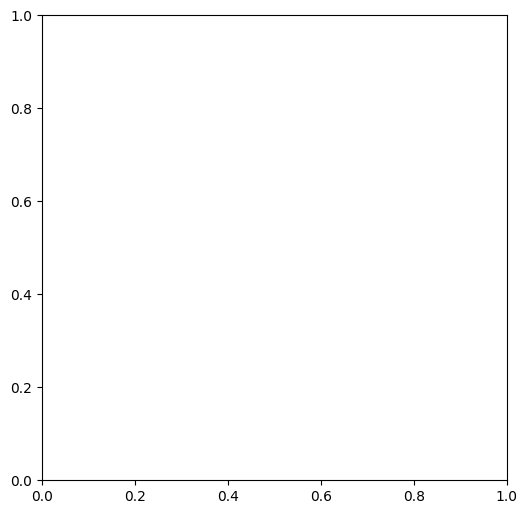

In [6]:
# Visualize the board
if 'board' in dir():
    plt.figure(figsize=(6, 12))
    plt.imshow(board, cmap='tab10', vmin=0, vmax=8)
    plt.colorbar(label='Cell value')
    plt.title('Board State\n(0=empty, 1=wall, 2-8=pieces)')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

## 4. Test Feature Calculations

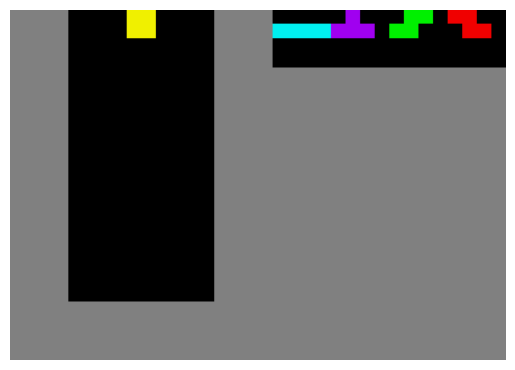

In [11]:
obs, info = env.reset(seed=41)

frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [12]:
# Feature calculation functions (same as train_lin_grouped.py)

def _get_board_array(board) -> np.ndarray:
    """Extract the board array from various possible formats."""
    if isinstance(board, dict):
        return np.asarray(board.get("board", board))
    return np.asarray(board)


def get_column_heights(board) -> list:
    """Compute column heights."""
    board = _get_board_array(board)
    if board.ndim != 2:
        print(f"WARNING: board.ndim = {board.ndim}, expected 2")
        return []
    
    heights_column = []
    for col in range(board.shape[1]):
        if board[0, col] != 1:  # Skip wall columns
            row = 2
            while row < board.shape[0] and board[row, col] == 0:
                row += 1
            heights_column.append(board.shape[0] - row)
    return heights_column


def count_holes(board) -> int:
    """Count holes in the board."""
    board = _get_board_array(board)
    if board.ndim != 2:
        print(f"WARNING: board.ndim = {board.ndim}, expected 2")
        return 0
    
    nb_holes = 0
    for row in range(board.shape[0]):
        for col in range(board.shape[1]):
            if row > 1 and board[row, col] == 0 and board[row-1, col] != 0:
                nb_holes += 1
    return nb_holes


def compute_bumpiness(board) -> int:
    """Compute bumpiness."""
    heights = get_column_heights(board)
    if len(heights) < 2:
        return 0
    bumpiness = 0
    for i in range(len(heights) - 1):
        bumpiness += abs(heights[i] - heights[i+1])
    return bumpiness

In [13]:
# Test on the board we extracted
print("Testing feature calculations on board...")
print(f"\nBoard shape: {board.shape}")
print(f"Board ndim: {board.ndim}")

heights = get_column_heights(board)
holes = count_holes(board)
bumpiness = compute_bumpiness(board)

print(f"\n--- Results ---")
print(f"Column heights: {heights}")
print(f"Number of heights: {len(heights)}")
print(f"Holes: {holes}")
print(f"Bumpiness: {bumpiness}")

Testing feature calculations on board...

Board shape: (13,)
Board ndim: 1

--- Results ---
Column heights: []
Number of heights: 0
Holes: 0
Bumpiness: 0


## 5. Take Some Steps and Check Features

In [14]:
# Get action mask
action_mask = info.get("action_mask", None)
print(f"Action mask type: {type(action_mask)}")
if action_mask is not None:
    if isinstance(action_mask, (list, tuple)):
        action_mask = action_mask[0] if len(action_mask) > 0 else action_mask
    action_mask = np.asarray(action_mask)
    print(f"Action mask shape: {action_mask.shape}")
    print(f"Valid actions: {np.sum(action_mask == 1)} / {len(action_mask)}")

Action mask type: <class 'numpy.ndarray'>
Action mask shape: (40,)
Valid actions: 36 / 40


In [15]:
# Take a random valid action
valid_actions = np.where(action_mask == 1)[0]
if len(valid_actions) > 0:
    action = np.random.choice(valid_actions)
    print(f"Taking action: {action}")
    
    next_obs, reward, terminated, truncated, next_info = env.step(action)
    
    print(f"\nReward: {reward}")
    print(f"Terminated: {terminated}")
    print(f"Lines cleared: {next_info.get('lines_cleared', 'N/A')}")
    
    # Get next board
    if "board" in next_info:
        next_board = next_info["board"]
        if isinstance(next_board, (list, tuple)):
            next_board = next_board[0]
        if isinstance(next_board, dict):
            next_board = next_board.get('board', next_board)
        next_board = np.asarray(next_board)
        
        print(f"\nNext board shape: {next_board.shape}")
        
        # Compute features
        next_heights = get_column_heights(next_board)
        next_holes = count_holes(next_board)
        next_bumpiness = compute_bumpiness(next_board)
        
        print(f"\n--- Next State Features ---")
        print(f"Column heights: {next_heights}")
        print(f"Holes: {next_holes}")
        print(f"Bumpiness: {next_bumpiness}")

Taking action: 5

Reward: 1
Terminated: False
Lines cleared: 0

Next board shape: (13,)

--- Next State Features ---
Column heights: []
Holes: 0
Bumpiness: 0


## 6. Compare with policies.py Implementation

In [16]:
# Original policies.py functions
def heights_original(board):
    """Original heights function from policies.py"""
    heights_column = [] 
    for i in range(board.shape[1]):
        if (board[0,i] != 1):
            j = 2
            while (board[j,i] == 0) and (j < board.shape[0]): 
                j = j+1
            heights_column.append(j) 
    return heights_column

def holes_original(board):
    """Original holes function from policies.py"""
    nb_holes = 0
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if (i > 1) and (board[i,j] == 0) and (board[i-1,j] != 0): 
                nb_holes = nb_holes + 1
    return nb_holes

# Compare
print("Comparing implementations on next_board...")
if 'next_board' in dir():
    print(f"\nOriginal heights(): {heights_original(next_board)}")
    print(f"Our get_column_heights(): {get_column_heights(next_board)}")
    print(f"\nOriginal holes(): {holes_original(next_board)}")
    print(f"Our count_holes(): {count_holes(next_board)}")

Comparing implementations on next_board...


IndexError: tuple index out of range

## 7. Play Multiple Steps and Visualize

In [17]:
# Reset and play a few steps
obs, info = env.reset(seed=123)

boards_history = []
features_history = []

for step in range(10):
    # Get action mask
    action_mask = info.get("action_mask", np.ones(obs.shape[0]))
    if isinstance(action_mask, (list, tuple)):
        action_mask = action_mask[0]
    action_mask = np.asarray(action_mask)
    
    valid_actions = np.where(action_mask == 1)[0]
    if len(valid_actions) == 0:
        print(f"Step {step}: No valid actions, game over")
        break
    
    action = np.random.choice(valid_actions)
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Get board
    board = info.get("board", None)
    if board is not None:
        if isinstance(board, (list, tuple)):
            board = board[0]
        if isinstance(board, dict):
            board = board.get('board', board)
        board = np.asarray(board)
        
        boards_history.append(board.copy())
        features_history.append({
            'step': step,
            'heights': get_column_heights(board),
            'holes': count_holes(board),
            'bumpiness': compute_bumpiness(board),
            'reward': reward,
            'lines': info.get('lines_cleared', 0)
        })
    
    if terminated:
        print(f"Step {step}: Game terminated")
        break

print(f"\nPlayed {len(features_history)} steps")


Played 10 steps


In [18]:
# Show features over time
import pandas as pd

if features_history:
    df = pd.DataFrame(features_history)
    print(df.to_string())

   step heights  holes  bumpiness  reward  lines
0     0      []      0          0       1      0
1     1      []      0          0       1      0
2     2      []      0          0       1      0
3     3      []      0          0       1      0
4     4      []      0          0       1      0
5     5      []      0          0       1      0
6     6      []      0          0       1      0
7     7      []      0          0       1      0
8     8      []      0          0       1      0
9     9      []      0          0       1      0


TypeError: Invalid shape (13,) for image data

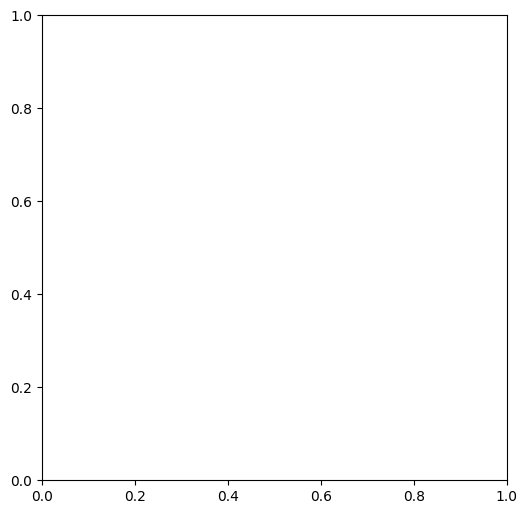

In [19]:
# Visualize last board
if boards_history:
    last_board = boards_history[-1]
    plt.figure(figsize=(6, 12))
    plt.imshow(last_board, cmap='tab10', vmin=0, vmax=8)
    plt.colorbar(label='Cell value')
    plt.title(f'Board after {len(boards_history)} steps')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()
    
    print(f"\nFeatures:")
    print(f"  Heights: {get_column_heights(last_board)}")
    print(f"  Holes: {count_holes(last_board)}")
    print(f"  Bumpiness: {compute_bumpiness(last_board)}")

In [ ]:
env.close()